In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData

from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.network.omics_distance import compute_expression_correlations, compute_annotation_similarity
from moge.visualization.plot import plot_matrix

# Heterogeneous Network

In [2]:
# READ Edgeslist
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                              directed=False)
# network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                              directed=True)
# network.remove_extra_nodes()

In [3]:
# WRITE Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                   data=True)

# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                   data=True)

In [ ]:
import pickle

with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_test_05_val_01_seed_0.pickle', 'wb') as file:
    pickle.dump(network, file)

# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'rb') as file:
#     network = pickle.load(file)
# #     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

#  Split Network to train test and write to file

In [16]:
from moge.evaluation.utils import mask_test_edges
adj_train, train_edges, \
val_edges, test_edges = mask_test_edges(network.get_adjacency_matrix(edge_type='d', node_list=node_list), 
                                                 is_directed=True,
                                                 test_frac=.0, val_frac=.00,
                                                 prevent_disconnect=True, verbose=True)

preprocessing...
creating true edges...
edges in MST: 18383
Num WCC:  3790
Largest WCC num nodes:  18365
Largest WCC num edges:  354795
Fraction of train edges with both endpoints in L-WCC:  1.0
Fraction of test edges with both endpoints in L-WCC:  N/A
Fraction of val edges with both endpoints in L-WCC:  N/A
final checks for disjointness...
creating adj_train...
Done with train-test split!
Num train edges (true, ): ( 354795 , 
Num test edges (true, ): ( 0 , 
Num val edges (true, ): ( 0 , 


In [ ]:
from moge.evaluation.utils import split_train_test_network

network_train, val_edges_dict, test_edges_dict = split_train_test_network(network, node_list, 
                                                          test_frac=.05, val_frac=.01, edge_types=["u", "d"], 
                                                          seed=0)

Removed 587782 test, and 117556 val, type u edges


In [4]:
print("edges: ", network_train.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

edges:  375524


In [5]:
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

edges:  375524


In [6]:
network_train.G.number_of_edges()

405768

# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [23]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

isolated nodes: 1988 , out of total nodes: 22342
edges:  12171466


In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

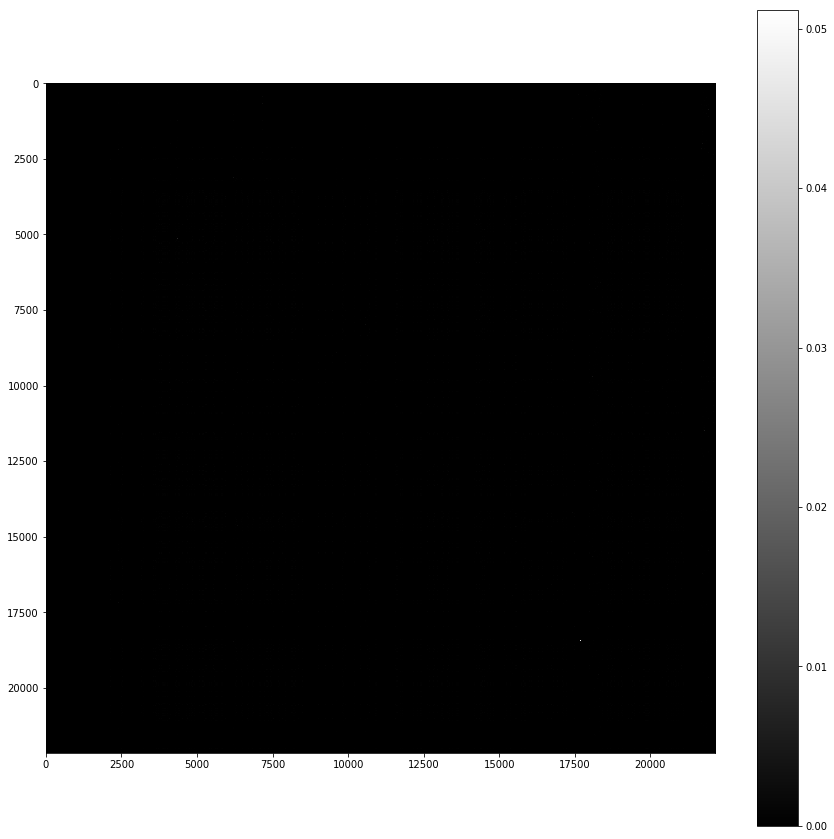

In [40]:
# Scatter plot of original graph adjacency matrix
plt.figure(figsize=(15, 15))
plt.imshow(graph_emb.get_reconstructed_adj(edge_type="u"), interpolation='none', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Training Source Target Graph Embedding

In [92]:
import tensorflow as tf
tf.reset_default_graph()
sess.close()
sess = tf.InteractiveSession()

In [93]:
with tf.name_scope('inputs'):
    E_i_ = tf.sparse_placeholder(tf.float32, name="E_i_")
    is_directed = tf.placeholder(tf.bool, name="is_directed")
    i = tf.Variable(int, name="i", trainable=False)


emb_s = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_t = tf.Variable(initial_value=tf.random_uniform([len(network.all_nodes), 64], -1, 1),
                         validate_shape=True, dtype=tf.float32,
                         name="emb_s", trainable=True)

emb_c = tf.concat([emb_s, emb_t], axis=1, name="emb_concat")

# 1st order (directed proximity)
p_1 = tf.sigmoid(tf.matmul(tf.slice(emb_s, [i, 0], [1, emb_s.get_shape()[1]]),
                           emb_t,
                           transpose_b=True, name="p_1_inner_prod"), name="p_1")
# print("E_i_:", E_i_)
# print("p_1:", p_1)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_1)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)), ))

loss_f1 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1))), name="loss_f1")

# 2nd order proximity
p_2_exps = tf.matmul(tf.slice(emb_c, [i, 0], [1, emb_c.get_shape()[1]], name="p_2_exps_i"),
                    emb_c,
                    transpose_b=True) # dim (1, n_nodes)
p_2 = tf.nn.softmax(p_2_exps - tf.reduce_max(p_2_exps, axis=1),
                             axis=1, name="p_2_softmax")
# print("p_2:", p_2)
# print("tf.sparse_tensor_dense_matmul(E_i_, tf.log(p_2)):", tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))))
loss_f2 = tf.reduce_sum(-tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_2))), name="loss_f2")

loss = tf.cond(is_directed, true_fn=lambda: loss_f1, false_fn=lambda: loss_f2)

# Add the loss value as a scalar to summary.
tf.summary.scalar('loss', loss)
# tf.summary.scalar("E_i_.dense_shape", E_i_.dense_shape)
merged = tf.summary.merge_all()

# Initialize variables
init_op = tf.global_variables_initializer()

# SGD Optimizer
optimizer = tf.train.GradientDescentOptimizer(0.1)\
    .minimize(loss, var_list=[emb_s, emb_t])

sess.run(init_op)

In [83]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return indices, coo.data, coo.shape


In [17]:
adj = network.get_regulatory_edges_adjacency()

In [58]:
Ed_rows, Ed_cols = adj.nonzero()
Ed_random_idx = list(np.unique(Ed_rows))

In [94]:
idx=3
Ed_i_sparse = convert_sparse_matrix_to_sparse_tensor(adj[idx, :])
feed_dict = {E_i_: Ed_i_sparse, is_directed: True, i: idx}
feed_dict

{<tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fcdc32aa828>: (matrix([[    0,  1871],
          [    0,  1886],
          [    0,  1894],
          ...,
          [    0, 22136],
          [    0, 22141],
          [    0, 22151]], dtype=int32),
  array([0.49, 0.59, 1.  , ..., 0.57, 1.  , 1.  ]),
  (1, 22154)),
 <tf.Tensor 'inputs/is_directed:0' shape=<unknown> dtype=bool>: True,
 <tf.Variable 'inputs/i:0' shape=() dtype=int32_ref>: 3}

In [95]:
sparse_matmul_1 = tf.sparse_tensor_dense_matmul(E_i_, tf.transpose(tf.log(p_1)))

In [96]:
_, summary, loss_val, a1, a2, a3 = sess.run([optimizer, merged, loss, p_1, p_2, sparse_matmul_1], feed_dict=feed_dict)
print(loss_val, a1.shape, a2.shape, a3.shape)

1493.6848 (1, 22154) (1, 22154) (1, 1)


# Training SourceTargetGraphEmbedding

In [3]:
from moge.embedding.siamese_dual_embedding import SiameseGraphEmbedding

graph_emb = SiameseGraphEmbedding(d=64, lr=0.1, Ed_Eu_ratio=0.1, epochs=5, batch_size=5000)
graph_emb.learn_embedding(network, seed=0)


Using TensorFlow backend.


Directed edges training size: 354795
Undirected edges training size: 5877828
Training 6232 iterations, with directed_edges_batch_size 500 and undirected_edges_batch_size 4500
iteration: 0 f1_loss 1.094793069597974 f2_loss 35.67647828144497
iteration: 1 f1_loss 1.0527278069449821 f2_loss 26.328566664483812
iteration: 2 f1_loss 1.1258578448394547 f2_loss 20.85005632241567
iteration: 3 f1_loss 1.0723086933320156 f2_loss 17.80677538553874
iteration: 4 f1_loss 1.1101176360579847 f2_loss 15.943636889351739
iteration: 5 f1_loss 1.0698202279836697 f2_loss 14.573521719826593
iteration: 6 f1_loss 1.066695525808842 f2_loss 13.825059656143189
iteration: 7 f1_loss 0.9973701540701441 f2_loss 13.450057130601671
iteration: 8 f1_loss 1.0462180690043605 f2_loss 13.021753844685025
iteration: 9 f1_loss 0.9668041735508014 f2_loss 12.59213787820604
iteration: 10 f1_loss 1.043032511653495 f2_loss 12.413508255057865
iteration: 11 f1_loss 0.9962405444072793 f2_loss 12.070848927709791
iteration: 12 f1_loss 1.03

iteration: 120 f1_loss 0.7379425686984323 f2_loss 7.858450051201714
iteration: 121 f1_loss 0.7250299948221073 f2_loss 7.783100547737545
iteration: 122 f1_loss 0.7558384663620964 f2_loss 7.835655759652456
iteration: 123 f1_loss 0.7717175888670609 f2_loss 7.742893113984002
iteration: 124 f1_loss 0.7442095931776567 f2_loss 7.788440580738915
iteration: 125 f1_loss 0.8472897354867309 f2_loss 7.8026348470052085
iteration: 126 f1_loss 0.7354217434788588 f2_loss 7.766444802761078
iteration: 127 f1_loss 0.6612372341956944 f2_loss 7.817123400529225
iteration: 128 f1_loss 0.7510900546640623 f2_loss 7.832207943227556
iteration: 129 f1_loss 0.7244303283626213 f2_loss 7.842584781328837
iteration: 130 f1_loss 0.7304953599944711 f2_loss 7.767725125577715
iteration: 131 f1_loss 0.7180173510825262 f2_loss 7.827586804707845
iteration: 132 f1_loss 0.6932069322168827 f2_loss 7.832787330733405
iteration: 133 f1_loss 0.7486195044484921 f2_loss 7.789208188480801
iteration: 134 f1_loss 0.7072074301489629 f2_lo

iteration: 241 f1_loss 0.5919521974460222 f2_loss 7.644606718911065
iteration: 242 f1_loss 0.5754393861354329 f2_loss 7.625279371473525
iteration: 243 f1_loss 0.500696119426284 f2_loss 7.683805808491177
iteration: 244 f1_loss 0.544797795322258 f2_loss 7.670294747988383
iteration: 245 f1_loss 0.5729880958693102 f2_loss 7.629141319168938
iteration: 246 f1_loss 0.5443560862969608 f2_loss 7.6599381823009915
iteration: 247 f1_loss 0.5123613392990083 f2_loss 7.686119930532244
iteration: 248 f1_loss 0.588880049132742 f2_loss 7.636435087680817
iteration: 249 f1_loss 0.5001209909822791 f2_loss 7.647678723812104
iteration: 250 f1_loss 0.49316539023909717 f2_loss 7.632613796393077
iteration: 251 f1_loss 0.5034003149364144 f2_loss 7.613536157713996
iteration: 252 f1_loss 0.48220536348596216 f2_loss 7.640784531275432
iteration: 253 f1_loss 0.49529049010924064 f2_loss 7.659256687164307
iteration: 254 f1_loss 0.5173373811494093 f2_loss 7.679755456580056
iteration: 255 f1_loss 0.5444828660958446 f2_lo

iteration: 361 f1_loss 0.3643406678907922 f2_loss 7.610074807802836
iteration: 362 f1_loss 0.3652572108847089 f2_loss 7.569962208112081
iteration: 363 f1_loss 0.3309016013131477 f2_loss 7.615453368451861
iteration: 364 f1_loss 0.3688703502533026 f2_loss 7.552057947317759
iteration: 365 f1_loss 0.33433864136901686 f2_loss 7.589825654188792
iteration: 366 f1_loss 0.33942597058659885 f2_loss 7.583043429374695
iteration: 367 f1_loss 0.3434304676668253 f2_loss 7.570907266245948
iteration: 368 f1_loss 0.3460802810527384 f2_loss 7.607419255309635
iteration: 369 f1_loss 0.32512735097028783 f2_loss 7.576458639992608
iteration: 370 f1_loss 0.33810932133870664 f2_loss 7.563762437476052
iteration: 371 f1_loss 0.33694941180059684 f2_loss 7.618778031110764
iteration: 372 f1_loss 0.34802253004060185 f2_loss 7.611701475514306
iteration: 373 f1_loss 0.3505748539469205 f2_loss 7.583145318614112
iteration: 374 f1_loss 0.3586569384234026 f2_loss 7.596777719550663
iteration: 375 f1_loss 0.30375402689463227

iteration: 481 f1_loss 0.22551184415142053 f2_loss 7.554654616408878
iteration: 482 f1_loss 0.23184045752696694 f2_loss 7.5406957317590715
iteration: 483 f1_loss 0.23549430083262268 f2_loss 7.556128750165303
iteration: 484 f1_loss 0.23947465309817925 f2_loss 7.5531889095571305
iteration: 485 f1_loss 0.2306474274833163 f2_loss 7.567807120482127
iteration: 486 f1_loss 0.2650411457249429 f2_loss 7.57233800289366
iteration: 487 f1_loss 0.2715592667208985 f2_loss 7.582072417961227
iteration: 488 f1_loss 0.19435827291794702 f2_loss 7.572061663362715
iteration: 489 f1_loss 0.17964123670535628 f2_loss 7.557870996634166
iteration: 490 f1_loss 0.2129912175403151 f2_loss 7.567944335195754
iteration: 491 f1_loss 0.19479873332113493 f2_loss 7.552194393952687
iteration: 492 f1_loss 0.22660880352708046 f2_loss 7.564577359199524
iteration: 493 f1_loss 0.2290355027061014 f2_loss 7.559850493748983
iteration: 494 f1_loss 0.21747192164190346 f2_loss 7.560865843402015
iteration: 495 f1_loss 0.2369362981666

iteration: 601 f1_loss 0.14538316809137178 f2_loss 7.559707952658336
iteration: 602 f1_loss 0.19148740419506793 f2_loss 7.538170715886686
iteration: 603 f1_loss 0.17586751522634586 f2_loss 7.529817454629474
iteration: 604 f1_loss 0.15629647839690733 f2_loss 7.6035469539695315
iteration: 605 f1_loss 0.14706820425507613 f2_loss 7.553858798185984
iteration: 606 f1_loss 0.1529327659503906 f2_loss 7.542441423892975
iteration: 607 f1_loss 0.15115186848647136 f2_loss 7.4968262068364355
iteration: 608 f1_loss 0.1753019605326117 f2_loss 7.532672658814325
iteration: 609 f1_loss 0.16319560189166077 f2_loss 7.559344899204042
iteration: 610 f1_loss 0.14482596698222916 f2_loss 7.525063399738736
iteration: 611 f1_loss 0.16127816145460383 f2_loss 7.508388835138745
iteration: 612 f1_loss 0.14925129646109417 f2_loss 7.559456131908629
iteration: 613 f1_loss 0.1410671909672674 f2_loss 7.555716613557603
iteration: 614 f1_loss 0.16340328916162253 f2_loss 7.521611763848199
iteration: 615 f1_loss 0.1669729236

iteration: 721 f1_loss 0.12625130466117115 f2_loss 7.516576387617323
iteration: 722 f1_loss 0.0971758835468936 f2_loss 7.515914204544491
iteration: 723 f1_loss 0.12246633207559353 f2_loss 7.510320521963967
iteration: 724 f1_loss 0.12160809083649655 f2_loss 7.492235609438684
iteration: 725 f1_loss 0.11906633817485272 f2_loss 7.532352403561275
iteration: 726 f1_loss 0.13063606708828593 f2_loss 7.538861337065697
iteration: 727 f1_loss 0.12560159669516724 f2_loss 7.523638543446859
iteration: 728 f1_loss 0.12468156985222595 f2_loss 7.530565074099434
iteration: 729 f1_loss 0.11779737342281442 f2_loss 7.491656326264143
iteration: 730 f1_loss 0.10040313763046288 f2_loss 7.4951645569271514
iteration: 731 f1_loss 0.11857698289128893 f2_loss 7.517827563974593
iteration: 732 f1_loss 0.10717454298611301 f2_loss 7.538936314847734
iteration: 733 f1_loss 0.10156012781245226 f2_loss 7.546775309085846
iteration: 734 f1_loss 0.13153492707209807 f2_loss 7.496556921535068
iteration: 735 f1_loss 0.103780718

iteration: 841 f1_loss 0.11119991873731487 f2_loss 7.53308018316163
iteration: 842 f1_loss 0.12504597140150145 f2_loss 7.5317048657205365
iteration: 843 f1_loss 0.09141952352701628 f2_loss 7.510120372957654
iteration: 844 f1_loss 0.09698025746416533 f2_loss 7.544052427768707
iteration: 845 f1_loss 0.11882278209074866 f2_loss 7.5026027494801415
iteration: 846 f1_loss 0.1196111683904055 f2_loss 7.500846624745263
iteration: 847 f1_loss 0.10022497178209597 f2_loss 7.5375154415898855
iteration: 848 f1_loss 0.11645093488255225 f2_loss 7.517074540350173
iteration: 849 f1_loss 0.09520081196306274 f2_loss 7.51948837574323
iteration: 850 f1_loss 0.12532671183725325 f2_loss 7.501854891512129
iteration: 851 f1_loss 0.09114019060907594 f2_loss 7.496162075383795
iteration: 852 f1_loss 0.1166357655483007 f2_loss 7.492731637001038
iteration: 853 f1_loss 0.10426461420729174 f2_loss 7.490624101665285
iteration: 854 f1_loss 0.1161726365296563 f2_loss 7.51414866566658
iteration: 855 f1_loss 0.103275053129

iteration: 960 f1_loss 0.10915856490143051 f2_loss 7.499085793150796
iteration: 961 f1_loss 0.0920024179722459 f2_loss 7.484896144919925


In [5]:
graph_emb.import_embedding("/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_source_target_embeddings_128_seed_0.embeddings",
                          node_list=network.all_nodes)
# graph_emb.save_embeddings("miRNA-mRNA_source_target_embeddings_128_seed_0.embeddings")

In [17]:
adj = graph_emb.get_reconstructed_adj(edge_type='d')

In [18]:
from moge.evaluation.link_prediction import largest_indices, select_top_k_link_predictions
adj[select_top_k_link_predictions(100000, adj, train_edges)]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

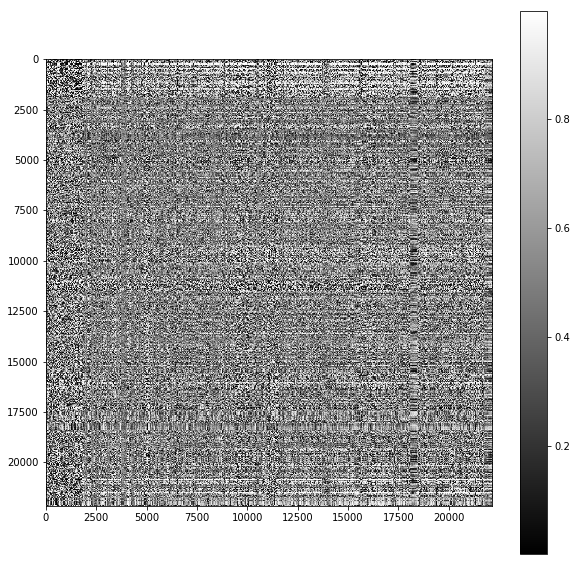

In [10]:
# plot_matrix(graph_emb.get_reconstructed_adj(edge_type='u'), colorbar=True)
plot_matrix(adj, colorbar=True)

# Import different models

In [30]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/miRNA-mRNA_LINE.txt", 
                          node_list=network.all_nodes)

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt", 
                          node_list=network.all_nodes)

node_list = list(set(line_emb.node_list) & set(node2vec_emb.node_list))

In [31]:
models = []
models.append(graph_emb)
models.append(line_emb)
models.append(node2vec_emb)

In [23]:
from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE

# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
models.append(GraphFactorization(d=128, max_iter=100, eta=1*10**-4, regu=1.0))
# models.append(LaplacianEigenmaps(d=200))
models.append(LocallyLinearEmbedding(d=128))
models.append(node2vec(d=128, max_iter=10, walk_len=5, num_walks=10, con_size=10, ret_p=1, inout_p=1))
# models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
#                    K=3, n_units=[50, 15,], rho=0.3, 
#                    n_iter=100, xeta=0.01, n_batch=500))

# models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

# Evaluate Graph Reconstruction

In [ ]:
node_list = list(set(line_emb.node_list) & set(graph_emb.node_list))


In [ ]:
from moge.evaluation.graph_reconstruction import evaluateStaticGraphReconstruction
# Directed edges
for model in models:
    print("\n",model.get_method_name())
    norm, avg = evaluateStaticGraphReconstruction(network, model, edge_type="d", train_embedding=False,
                                                  sample_ratio=1.0, node_list=node_list)

    print(norm, avg)

In [ ]:
# Undirected edges
for model in models:
    print("\n",model.get_method_name())
    norm, avg = evaluateStaticGraphReconstruction(network, model, edge_type="u", train_embedding=False,
                                                  sample_ratio=1.0, node_list=node_list)
    print(norm, avg)

# Evaluate Link Prediction

In [26]:
from moge.evaluation.link_prediction import evaluate_top_k_link_prediction, evaluate_random_link_prediction
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

# Directed edges
for model in models:
    print("\n",model.get_method_name())
    scores = evaluate_top_k_link_prediction(top_k=1000, network=network, node_list=node_list,
                                 graph_emb=model, train_embedding=False,
                                 edge_type="d", test_frac=0.001, seed=0)
    print(scores)


 source_target_graph_embedding
test_edges: 354
{'precision': 0.0, 'recall': 0.0}

 LINE
test_edges: 354


IndexError: index 20238 is out of bounds for axis 0 with size 20171

In [13]:
# Undirected edges
for model in models:
    evaluate_top_k_link_prediction(top_k=100000, network=network, 
                             graph_emb=model, train_embedding=False,
                             edge_type="u", test_frac=0.001, seed=0)
    print(scores)

test_edges: 11755
top k predicted edges: [0.204 0.152 0.15  ... 0.001 0.001 0.001]


{'precision': 0.010771615742361355, 'recall': 0.09167517875383044}

In [41]:
# Evaluate random directed edge prediction
print(evaluate_random_link_prediction(top_k=10000, network=network, edge_type="d", test_frac=0.001, seed=0))
print(evaluate_random_link_prediction(top_k=100000, network=network, edge_type="u", test_frac=0.00001, seed=0))

{'precision': 0.0, 'recall': 0.0}
{'precision': 0.0, 'recall': 0.0}


# Import GEM Graph Embedding Methods

In [42]:
from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation.metrics import getPrecisionReport
from gem.evaluation.evaluate_link_prediction import evaluateStaticLinkPrediction

from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE
from moge.embedding.dual_graph_embedding import DualGraphEmbedding


Using TensorFlow backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /usr/local/cuda-9.0/include/channel_descriptor.h:62:0,\n                 from /usr/local/cuda-9.0/include/cuda_runtime.h:90,\n                 from /usr/include/cudnn.h:64,\n                 from /tmp/try_flags_sy4bbgau.c:4:\n/usr/local/cuda-9.0/include/cuda_runtime_api.h:2930:102: error: use of enum \xe2\x80\x98cudaFuncAttribute\xe2\x80\x99 without previous declaration\n extern __host__ __cudart_builtin__ cudaError_t CUDARTAPI cudaFuncSetAttribute(const void *func, enum cudaFuncAttribute attr, int value);\n                                                                                                      ^~~~~~~~~~~~~~~~~\n'
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


In [55]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
        embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

        Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
        MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, 
                                                                                 sample_ratio_e=0.0001, k=500000)
        print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
#         MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
#                                      train_ratio=0.8,
#                                      is_undirected=False)
#         print ("Link Prediction. MAP:", MAP)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

Num nodes: 23179, num edges: 199324

 lap_eigmap_svd lap_eigmap_svd_200
Laplacian matrix recon. error (low rank): 118.058668
lap_eigmap_svd:
	Training time: 156.647702


KeyboardInterrupt: 

# Node Visualization

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)